

### Prediction Model - Regression Problem

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

def load_data(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    return train, test

def preprocess_dates(df):
    df['week'] = pd.to_datetime(df['week'], format='%d/%m/%y')
    df = df.sort_values(['store_id', 'sku_id', 'week']).reset_index(drop=True)
    return df

def create_static_features(df):
    df['year'] = df['week'].dt.year
    df['month'] = df['week'].dt.month
    df['quarter'] = df['week'].dt.quarter
    df['day_of_year'] = df['week'].dt.dayofyear
    return df

def create_price_features(df):
    df['discount'] = df['base_price'] - df['total_price']
    df['discount_ratio'] = df['discount'] / df['base_price']
    df['price_ratio'] = df['total_price'] / df['base_price']
    df['total_price'] = df['total_price'].fillna(df['base_price'])
    df['discount'].fillna(0, inplace=True)
    df['discount_ratio'].fillna(0, inplace=True)
    df['price_ratio'].fillna(1, inplace=True)
    return df

def create_store_features(train, test):
    store_stats = train.groupby('store_id')['units_sold'].agg([
        'mean', 'std', 'median', 'min', 'max', 'count'
    ]).reset_index()
    store_stats.columns = ['store_id', 'store_mean_sales', 'store_std_sales',
                          'store_median_sales', 'store_min_sales', 'store_max_sales', 'store_count']

    store_featured = train.groupby('store_id')['is_featured_sku'].mean().reset_index()
    store_featured.columns = ['store_id', 'store_featured_pct']

    store_display = train.groupby('store_id')['is_display_sku'].mean().reset_index()
    store_display.columns = ['store_id', 'store_display_pct']

    train = train.merge(store_stats, on='store_id', how='left')
    train = train.merge(store_featured, on='store_id', how='left')
    train = train.merge(store_display, on='store_id', how='left')

    test = test.merge(store_stats, on='store_id', how='left')
    test = test.merge(store_featured, on='store_id', how='left')
    test = test.merge(store_display, on='store_id', how='left')

    return train, test

def create_product_features(train, test):
    sku_stats = train.groupby('sku_id')['units_sold'].agg([
        'mean', 'std', 'median', 'min', 'max'
    ]).reset_index()
    sku_stats.columns = ['sku_id', 'sku_mean_sales', 'sku_std_sales',
                        'sku_median_sales', 'sku_min_sales', 'sku_max_sales']

    sku_featured = train.groupby('sku_id')['is_featured_sku'].mean().reset_index()
    sku_featured.columns = ['sku_id', 'sku_featured_pct']

    sku_display = train.groupby('sku_id')['is_display_sku'].mean().reset_index()
    sku_display.columns = ['sku_id', 'sku_display_pct']

    train = train.merge(sku_stats, on='sku_id', how='left')
    train = train.merge(sku_featured, on='sku_id', how='left')
    train = train.merge(sku_display, on='sku_id', how='left')

    test = test.merge(sku_stats, on='sku_id', how='left')
    test = test.merge(sku_featured, on='sku_id', how='left')
    test = test.merge(sku_display, on='sku_id', how='left')

    return train, test

def create_store_product_features(train, test):
    store_sku_stats = train.groupby(['store_id', 'sku_id'])['units_sold'].agg([
        'mean', 'std', 'median', 'count'
    ]).reset_index()
    store_sku_stats.columns = ['store_id', 'sku_id', 'store_sku_mean_sales',
                              'store_sku_std_sales', 'store_sku_median_sales', 'store_sku_count']

    train = train.merge(store_sku_stats, on=['store_id', 'sku_id'], how='left')
    test = test.merge(store_sku_stats, on=['store_id', 'sku_id'], how='left')

    return train, test

def create_price_statistics(train, test):
    store_price = train.groupby('store_id')['total_price'].agg(['mean', 'std']).reset_index()
    store_price.columns = ['store_id', 'store_price_mean', 'store_price_std']

    sku_price = train.groupby('sku_id')['total_price'].agg(['mean', 'std']).reset_index()
    sku_price.columns = ['sku_id', 'sku_price_mean', 'sku_price_std']

    train = train.merge(store_price, on='store_id', how='left')
    train = train.merge(sku_price, on='sku_id', how='left')

    test = test.merge(store_price, on='store_id', how='left')
    test = test.merge(sku_price, on='sku_id', how='left')

    return train, test

def prediction_feature_engineering(train, test):
    train = preprocess_dates(train)
    test = preprocess_dates(test)

    train = create_static_features(train)
    test = create_static_features(test)

    train = create_price_features(train)
    test = create_price_features(test)

    train, test = create_store_features(train, test)
    train, test = create_product_features(train, test)
    train, test = create_store_product_features(train, test)
    train, test = create_price_statistics(train, test)

    train.fillna(0, inplace=True)
    test.fillna(0, inplace=True)

    return train, test

def prepare_prediction_features(train, test):
    feature_cols = [
        'store_id', 'sku_id', 'total_price', 'base_price',
        'is_featured_sku', 'is_display_sku',
        'year', 'month', 'quarter', 'day_of_year',
        'discount', 'discount_ratio', 'price_ratio',
        'store_mean_sales', 'store_std_sales', 'store_median_sales',
        'store_min_sales', 'store_max_sales', 'store_featured_pct', 'store_display_pct',
        'sku_mean_sales', 'sku_std_sales', 'sku_median_sales',
        'sku_min_sales', 'sku_max_sales', 'sku_featured_pct', 'sku_display_pct',
        'store_sku_mean_sales', 'store_sku_std_sales', 'store_sku_median_sales',
        'store_price_mean', 'store_price_std', 'sku_price_mean', 'sku_price_std'
    ]

    available_features = [col for col in feature_cols if col in train.columns]

    X_train = train[available_features].copy()
    y_train = train['units_sold'].copy()
    X_test = test[[col for col in available_features if col in test.columns]].copy()

    return X_train, y_train, X_test, available_features

def train_prediction_model(X_train, y_train, X_val, y_val):
    model = RandomForestRegressor(
        n_estimators=150,
        max_depth=25,
        min_samples_split=8,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mape = mean_absolute_percentage_error(y_val, y_pred)

    return model, {'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}

def train_gradient_boosting_predictor(X_train, y_train, X_val, y_val):
    model = GradientBoostingRegressor(
        n_estimators=150,
        max_depth=12,
        learning_rate=0.08,
        subsample=0.85,
        min_samples_split=8,
        min_samples_leaf=4,
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mape = mean_absolute_percentage_error(y_val, y_pred)

    return model, {'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}

def ensemble_prediction(models, weights, X):
    predictions = []
    for model in models:
        predictions.append(model.predict(X))
    return np.average(predictions, axis=0, weights=weights)

def main_prediction():
    print("=" * 60)
    print("SALES PREDICTION MODEL - STATIC PREDICTION")
    print("=" * 60)

    print("\nLoading data...")
    train, test = load_data('train_0irEZ2H.csv', 'test_nfaJ3J5.csv')
    print(f"Train shape: {train.shape}, Test shape: {test.shape}")

    print("Feature engineering for prediction...")
    train, test = prediction_feature_engineering(train, test)
    print(f"After feature engineering - Train shape: {train.shape}, Test shape: {test.shape}")

    print("Preparing features...")
    X, y, X_test, feature_cols = prepare_prediction_features(train, test)
    print(f"Number of features: {len(feature_cols)}")

    print("Splitting data for validation...")
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")

    print("\nTraining Random Forest Predictor...")
    rf_model, rf_metrics = train_prediction_model(X_train, y_train, X_val, y_val)
    print(f"RF - RMSE: {rf_metrics['rmse']:.4f}, MAE: {rf_metrics['mae']:.4f}, R2: {rf_metrics['r2']:.4f}, MAPE: {rf_metrics['mape']:.4f}")

    print("Training Gradient Boosting Predictor...")
    gb_model, gb_metrics = train_gradient_boosting_predictor(X_train, y_train, X_val, y_val)
    print(f"GB - RMSE: {gb_metrics['rmse']:.4f}, MAE: {gb_metrics['mae']:.4f}, R2: {gb_metrics['r2']:.4f}, MAPE: {gb_metrics['mape']:.4f}")

    print("\nEnsemble prediction on validation set...")
    ensemble_pred = ensemble_prediction([rf_model, gb_model], [0.55, 0.45], X_val)
    ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_pred))
    ensemble_mae = mean_absolute_error(y_val, ensemble_pred)
    ensemble_r2 = r2_score(y_val, ensemble_pred)
    ensemble_mape = mean_absolute_percentage_error(y_val, ensemble_pred)
    print(f"Ensemble - RMSE: {ensemble_rmse:.4f}, MAE: {ensemble_mae:.4f}, R2: {ensemble_r2:.4f}, MAPE: {ensemble_mape:.4f}")

    print("\nTraining final models on full dataset...")
    rf_final = RandomForestRegressor(
        n_estimators=150,
        max_depth=25,
        min_samples_split=8,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1
    )
    rf_final.fit(X, y)

    gb_final = GradientBoostingRegressor(
        n_estimators=150,
        max_depth=12,
        learning_rate=0.08,
        subsample=0.85,
        min_samples_split=8,
        min_samples_leaf=4,
        random_state=42
    )
    gb_final.fit(X, y)

    print("Generating predictions for test set...")
    predictions = ensemble_prediction([rf_final, gb_final], [0.55, 0.45], X_test)
    predictions = np.maximum(predictions, 1)

    submission = pd.DataFrame({
        'record_ID': test['record_ID'],
        'units_sold': predictions
    })
    submission.to_csv('prediction_submission.csv', index=False)
    print("Predictions saved to prediction_submission.csv")
    print(f"Prediction statistics - Mean: {predictions.mean():.2f}, Std: {predictions.std():.2f}, Min: {predictions.min():.2f}, Max: {predictions.max():.2f}")

    return rf_final, gb_final, submission

if __name__ == "__main__":
    rf_model, gb_model, submission_df = main_prediction()

SALES PREDICTION MODEL - STATIC PREDICTION

Loading data...
Train shape: (150150, 9), Test shape: (13860, 8)
Feature engineering for prediction...
After feature engineering - Train shape: (150150, 39), Test shape: (13860, 38)
Preparing features...
Number of features: 34
Splitting data for validation...
Training set: (120120, 34), Validation set: (30030, 34)

Training Random Forest Predictor...
RF - RMSE: 23.4578, MAE: 11.6826, R2: 0.8463, MAPE: 0.3536
Training Gradient Boosting Predictor...
GB - RMSE: 20.5892, MAE: 10.7870, R2: 0.8816, MAPE: 0.3262

Ensemble prediction on validation set...
Ensemble - RMSE: 21.7185, MAE: 11.1017, R2: 0.8682, MAPE: 0.3375

Training final models on full dataset...
Generating predictions for test set...
Predictions saved to prediction_submission.csv
Prediction statistics - Mean: 48.02, Std: 45.23, Min: 4.10, Max: 685.88


### Forecasting Model - Statistical Models

TIME SERIES FORECASTING WITH VISUALIZATIONS - SEASONALITY & TREND ONLY

Loading training data...
Original data shape: (150150, 9)

Aggregating by week and store...
Aggregated by week and store: (9880, 3)

Aggregating to global weekly totals...
Global weekly totals: (130, 2)

GLOBAL LEVEL FORECASTING

Global Weekly Sales Forecasting Models Comparison:

1. ARIMA(1,1,1) Model...
   RMSE: 5588.6070, MAE: 4791.4738, MAPE: 0.0817%, R2: 0.0748

2. Exponential Smoothing (Statsmodels) Model...
   RMSE: 11446.4463, MAE: 10090.7004, MAPE: 0.1660%, R2: -2.8814

3. Naive Seasonal Forecast Model...
   RMSE: 13011.3607, MAE: 11091.9231, MAPE: 0.1841%, R2: -4.0152

4. Simple Exponential Smoothing (SES) Model...
   RMSE: 9982.1133, MAE: 8420.4193, MAPE: 0.1354%, R2: -1.9518

5. Triple Exponential Smoothing (Holt-Winters) Model...
   RMSE: 7307.2504, MAE: 5927.4647, MAPE: 0.0984%, R2: -0.5818

6. Seasonal Decomposition Forecast Model...

7. Autoregressive (AR) Model...
   RMSE: 8629.1003, MAE: 7353.9168

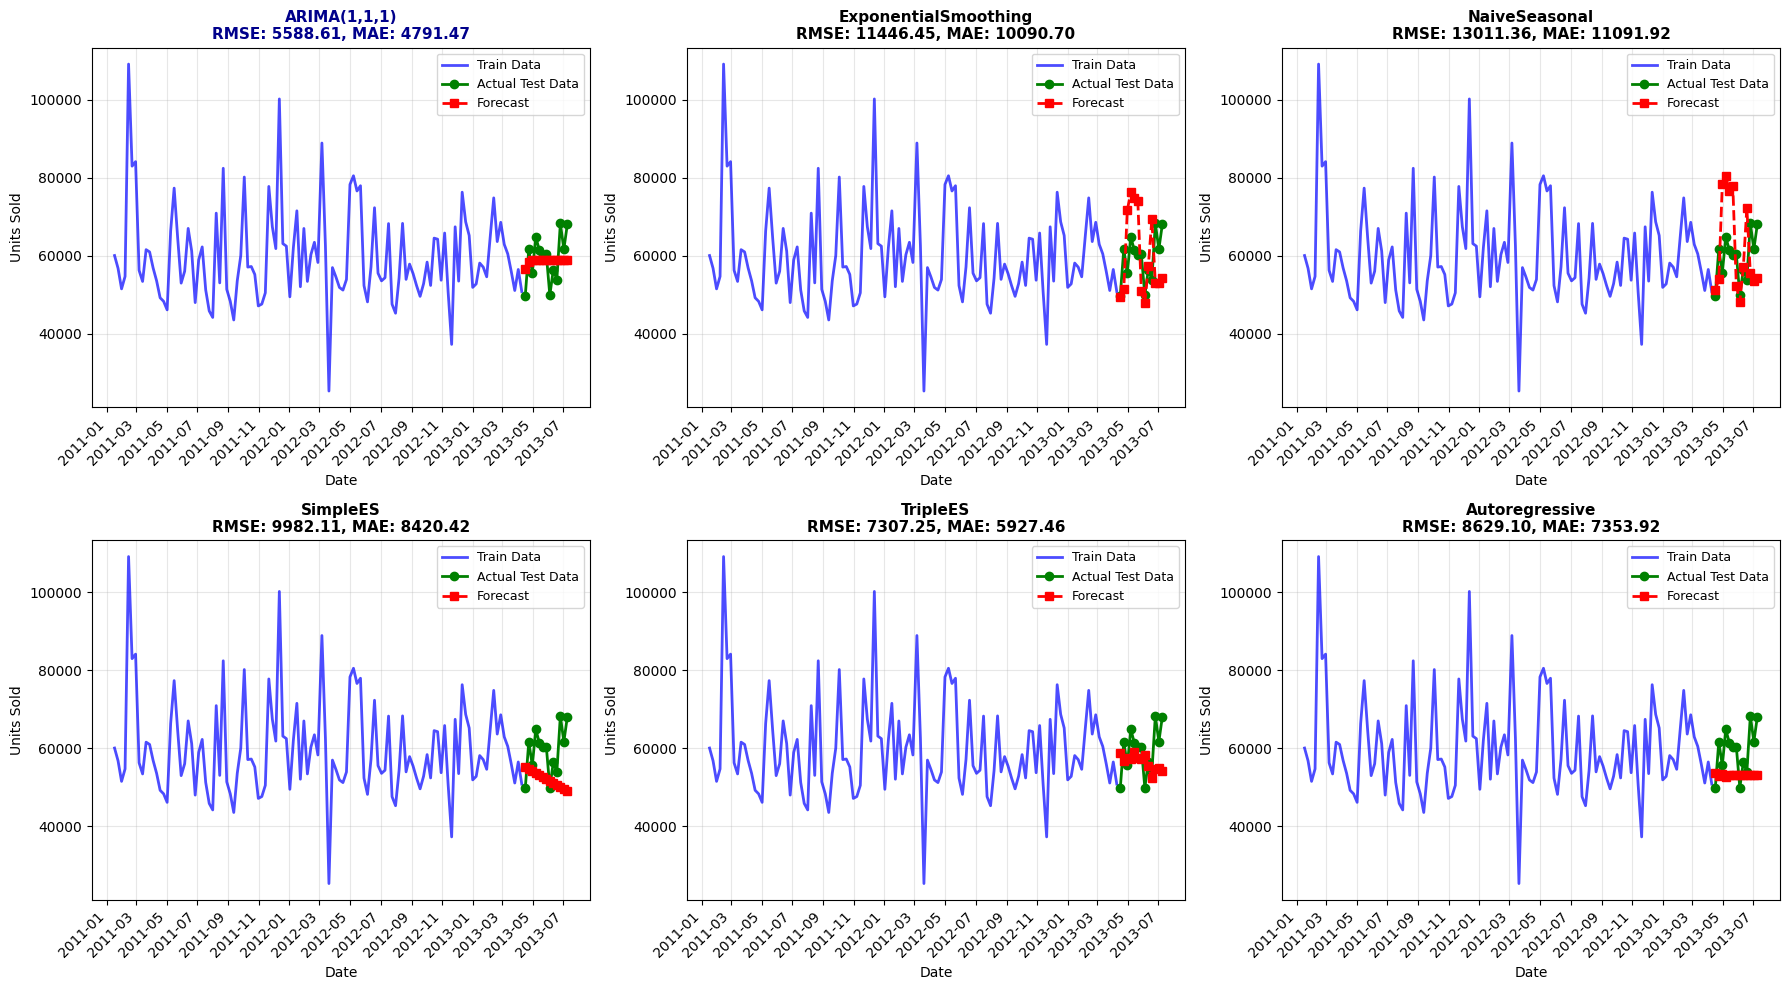


STORE-LEVEL FORECASTING

STORE-LEVEL FORECASTING RESULTS:

Store 8023:
  ARIMA                - RMSE: 295.8193, MAE: 212.8493, MAPE: 0.0803%
  ExponentialSmoothing - RMSE: 348.6922, MAE: 271.2304, MAPE: 0.1048%
  TripleES             - RMSE: 412.9226, MAE: 315.2467, MAPE: 0.1203%
  Autoregressive       - RMSE: 462.7862, MAE: 399.7262, MAPE: 0.1561%
  Best Store Model: ARIMA

  Generating visualization for Store 8023...

Plot saved: forecast_comparison_store_8023.png


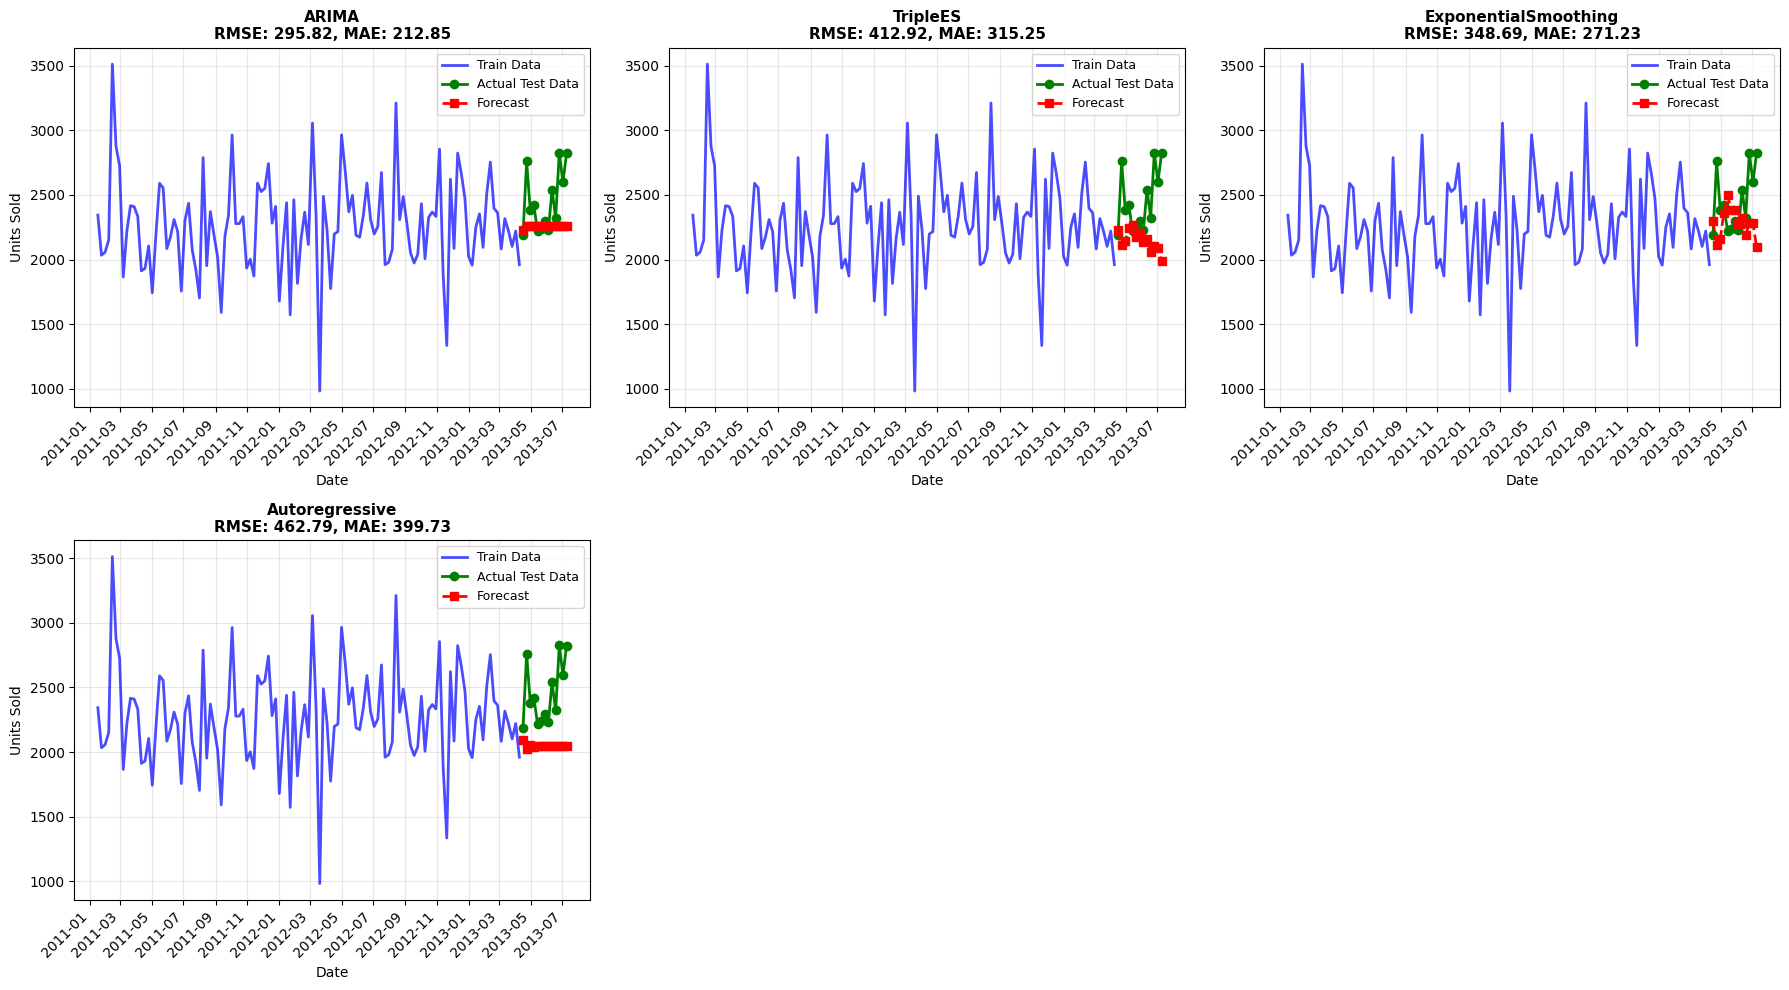


Store 8058:
  ARIMA                - RMSE: 103.4567, MAE: 84.5546, MAPE: 0.0991%
  TripleES             - RMSE: 128.4617, MAE: 107.4433, MAPE: 0.1285%
  ExponentialSmoothing - RMSE: 153.6340, MAE: 131.2541, MAPE: 0.1573%
  Autoregressive       - RMSE: 169.9249, MAE: 147.3295, MAPE: 0.1677%
  Best Store Model: ARIMA

  Generating visualization for Store 8058...

Plot saved: forecast_comparison_store_8058.png


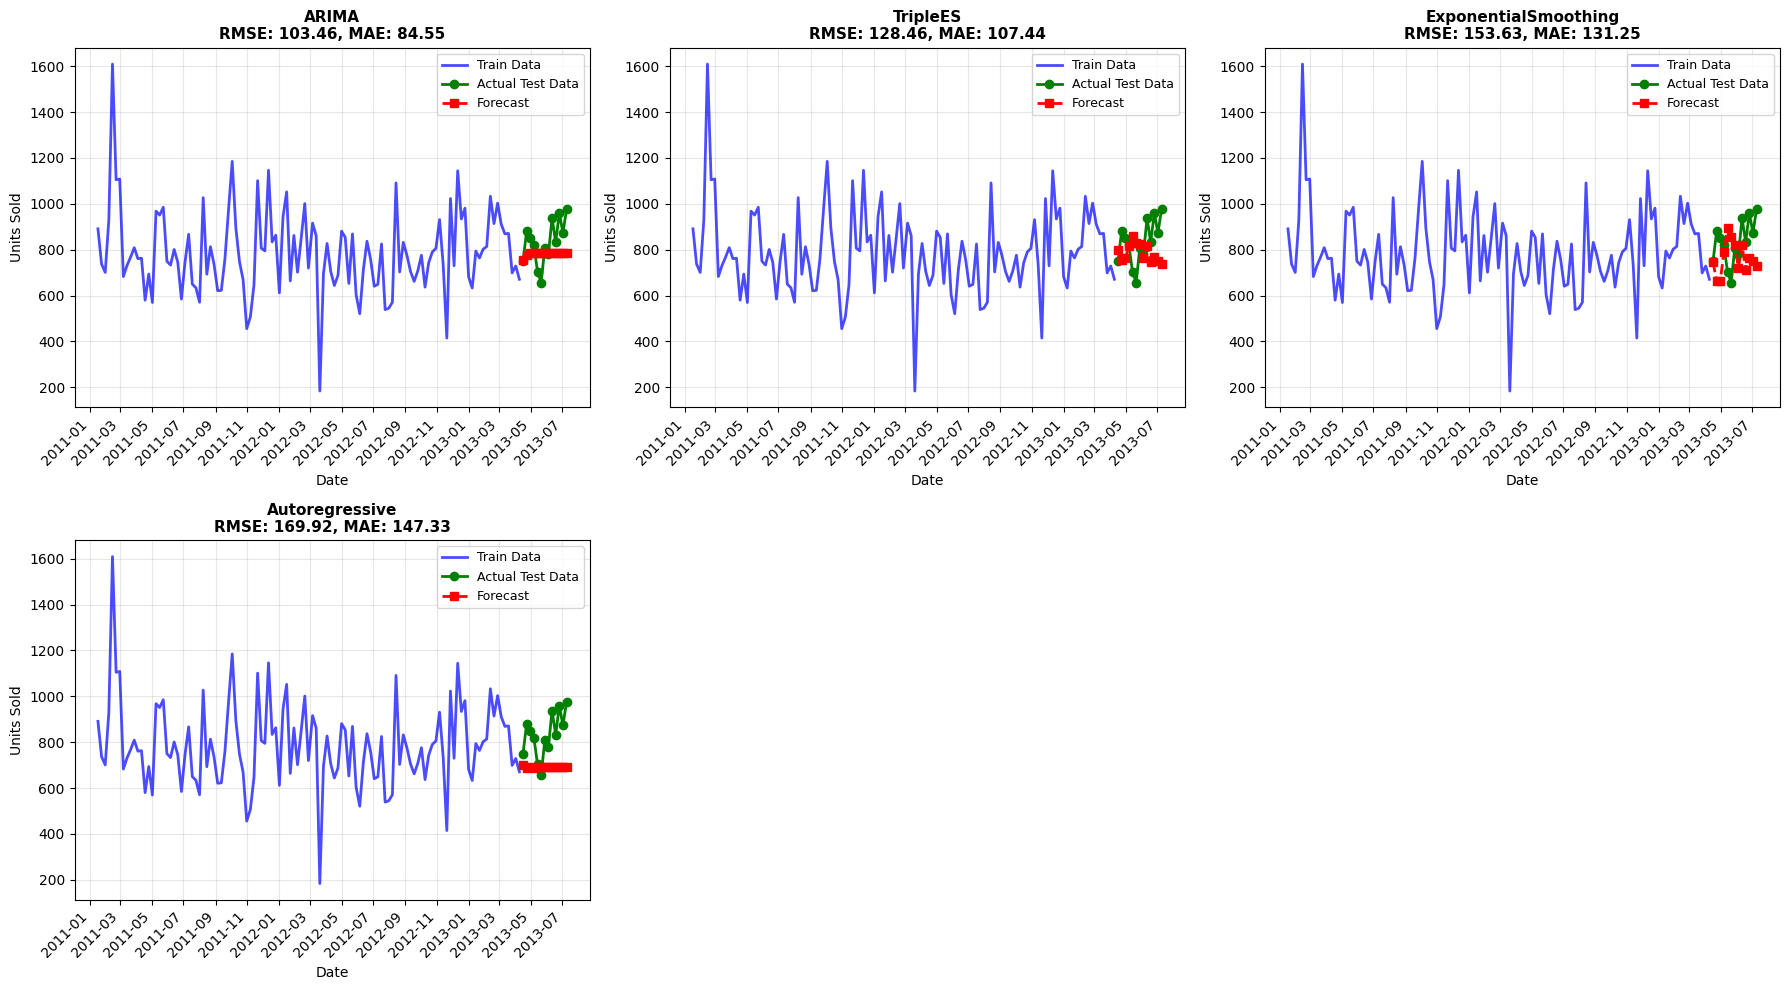


Store 8063:
  ARIMA                - RMSE: 51.9906, MAE: 44.4148, MAPE: 0.0688%
  Autoregressive       - RMSE: 59.4664, MAE: 48.6951, MAPE: 0.0732%
  ExponentialSmoothing - RMSE: 69.0570, MAE: 57.0860, MAPE: 0.0887%
  TripleES             - RMSE: 72.8679, MAE: 62.7878, MAPE: 0.1004%
  Best Store Model: ARIMA

  Generating visualization for Store 8063...

Plot saved: forecast_comparison_store_8063.png


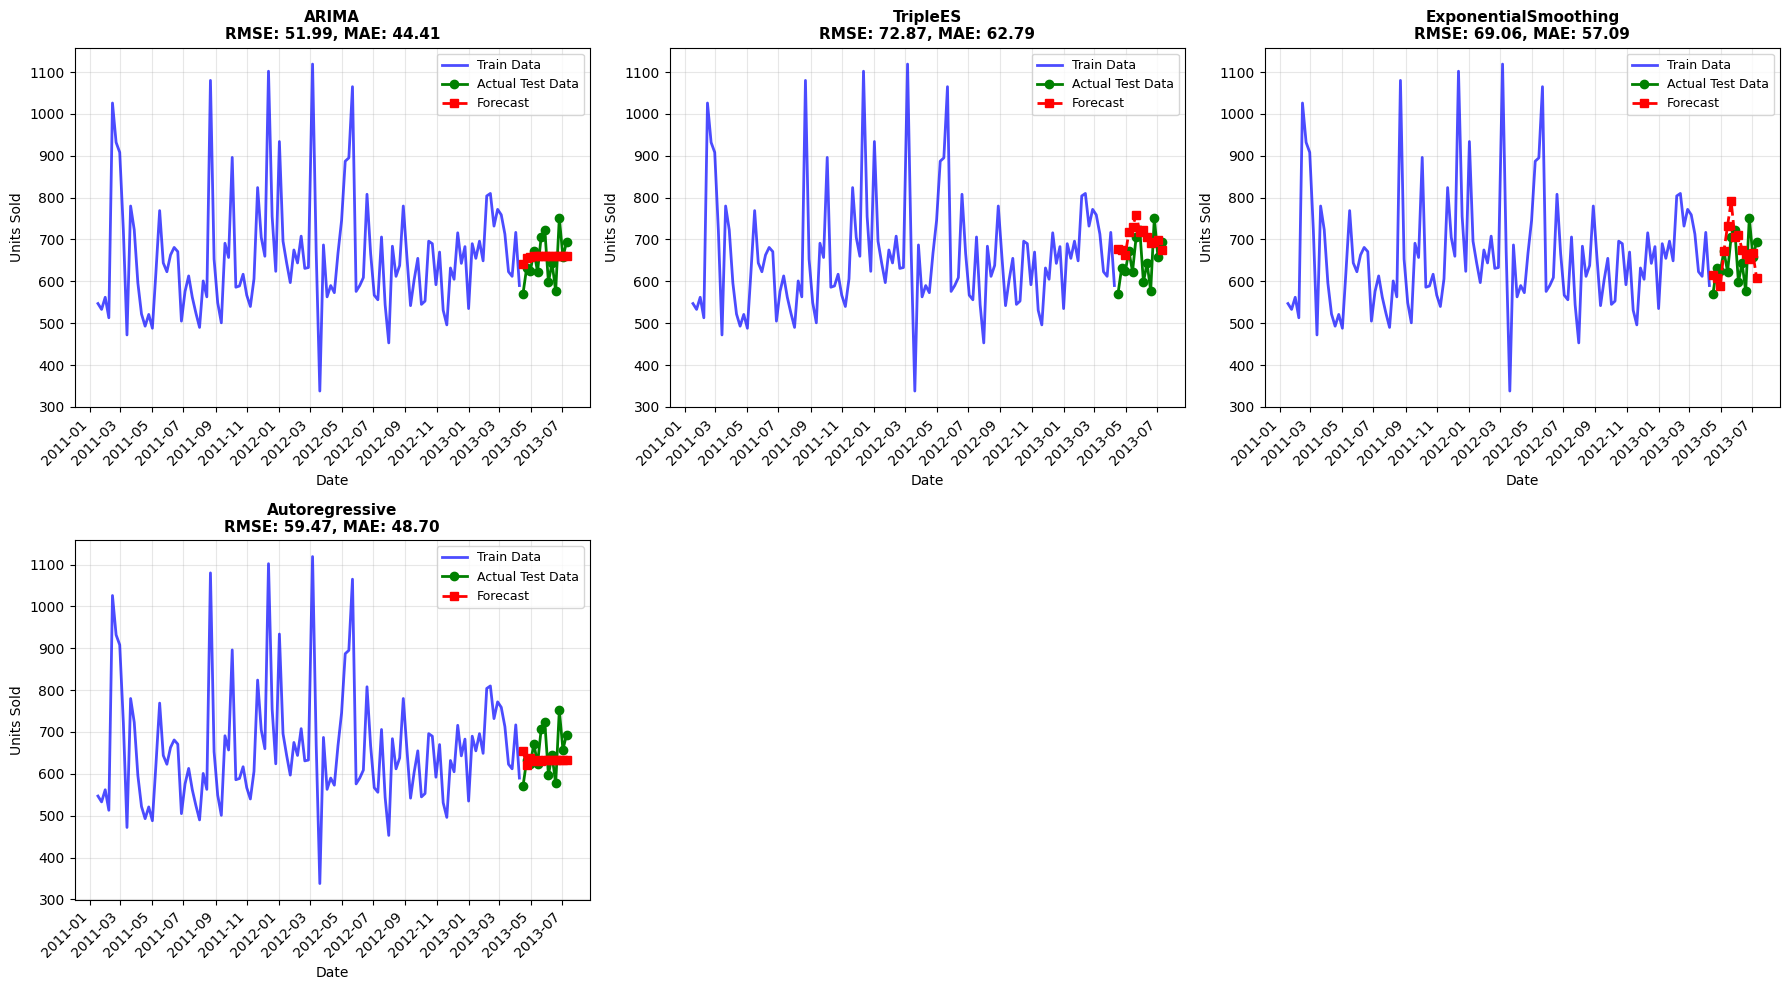


FINAL SUMMARY

Best Global Model: ARIMA(1,1,1)
Train Period: 117 weeks
Test Period: 13 weeks
Global Train Mean: 59718.06
Global Test Mean: 59374.54

Plots have been saved as PNG files for review.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

def load_train_data(train_path):
    train = pd.read_csv(train_path)
    train['week'] = pd.to_datetime(train['week'], format='%d/%m/%y')
    return train

def aggregate_by_week_store(train):
    train_agg = train.groupby(['week', 'store_id']).agg({'units_sold': 'sum'}).reset_index()
    train_agg = train_agg.sort_values(['store_id', 'week']).reset_index(drop=True)
    return train_agg

def aggregate_by_week(train):
    train_agg = train.groupby('week').agg({'units_sold': 'sum'}).reset_index()
    train_agg = train_agg.sort_values('week').reset_index(drop=True)
    return train_agg

def split_train_test(data, test_size=0.1):
    split_idx = int(len(data) * (1 - test_size))
    train = data[:split_idx].reset_index(drop=True)
    test = data[split_idx:].reset_index(drop=True)
    return train, test

def evaluate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2}

def fit_arima_model(train_series, order=(1, 1, 1)):
    try:
        model = ARIMA(train_series, order=order)
        fitted_model = model.fit()
        return fitted_model
    except:
        return None

def forecast_arima(fitted_model, steps):
    try:
        forecast = fitted_model.get_forecast(steps=steps)
        return forecast.predicted_mean.values
    except:
        return None

def fit_exponential_smoothing(train_series, seasonal_periods=52):
    try:
        model = ExponentialSmoothing(
            train_series,
            seasonal_periods=seasonal_periods,
            trend='add',
            seasonal='add',
            initialization_method='estimated'
        )
        fitted_model = model.fit(optimized=True)
        return fitted_model
    except:
        return None

def forecast_exponential_smoothing(fitted_model, steps):
    try:
        forecast = fitted_model.forecast(steps=steps)
        return forecast.values
    except:
        return None

def naive_seasonal_forecast(train_series, test_length, seasonal_period=52):
    forecast = []
    for i in range(test_length):
        idx = len(train_series) - seasonal_period + (i % seasonal_period)
        if idx >= 0 and idx < len(train_series):
            forecast.append(train_series.iloc[idx])
        else:
            forecast.append(train_series.mean())
    return np.array(forecast)

def exponential_smoothing_simple(train_series, test_length, alpha=0.3, beta=0.1):
    series = train_series.values.copy()
    level = series[0]
    trend = (series[1] - series[0]) if len(series) > 1 else 0

    for i in range(1, len(series)):
        prev_level = level
        level = alpha * series[i] + (1 - alpha) * (level + trend)
        trend = beta * (level - prev_level) + (1 - beta) * trend

    forecast = []
    for h in range(1, test_length + 1):
        forecast.append(level + h * trend)

    return np.array(forecast)

def triple_exponential_smoothing(train_series, test_length, alpha=0.2, beta=0.1, gamma=0.1, seasonal_period=52):
    series = train_series.values.copy()

    if len(series) < 2 * seasonal_period:
        return exponential_smoothing_simple(train_series, test_length, alpha, beta)

    level = series[:seasonal_period].mean()
    trend = (series[seasonal_period:2*seasonal_period].mean() - series[:seasonal_period].mean()) / seasonal_period
    seasonal = [(series[i] - level) / seasonal_period for i in range(seasonal_period)]

    for i in range(len(series)):
        if i >= seasonal_period:
            prev_level = level
            level = alpha * (series[i] - seasonal[i % seasonal_period]) + (1 - alpha) * (level + trend)
            trend = beta * (level - prev_level) + (1 - beta) * trend
            seasonal[i % seasonal_period] = gamma * (series[i] - level) + (1 - gamma) * seasonal[i % seasonal_period]

    forecast = []
    for h in range(test_length):
        forecast.append(level + (h + 1) * trend + seasonal[h % seasonal_period])

    return np.array(forecast)

def decompose_and_forecast(train_series, test_length, seasonal_period=52):
    try:
        if len(train_series) < 2 * seasonal_period:
            return None

        decomposition = seasonal_decompose(train_series, model='additive', period=seasonal_period, extrapolate='fill_value')
        trend = decomposition.trend.fillna(train_series.mean())
        seasonal = decomposition.seasonal
        residual = decomposition.resid.fillna(0)

        trend_last = trend.iloc[-1]
        trend_slope = (trend.iloc[-1] - trend.iloc[-seasonal_period]) / seasonal_period

        forecast = []
        for h in range(test_length):
            t_forecast = trend_last + (h + 1) * trend_slope
            s_forecast = seasonal.iloc[(len(seasonal) - seasonal_period + h) % seasonal_period]
            r_forecast = residual.mean()
            forecast.append(max(t_forecast + s_forecast + r_forecast, 1))

        return np.array(forecast)
    except:
        return None

def autoreg_forecast(train_series, test_length, lag=4):
    series = train_series.values.copy()
    forecast = []
    history = list(series[-lag:])

    for _ in range(test_length):
        avg = np.mean(history[-lag:])
        forecast.append(max(avg, 1))
        history.append(avg)

    return np.array(forecast)

def plot_forecast_comparison(train_data, test_data, y_train, y_test, model_forecasts, model_names, best_model):
    n_models = len(model_forecasts)
    cols = 3
    rows = (n_models + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    axes = axes.flatten()

    train_dates = train_data['week'].values
    test_dates = test_data['week'].values

    for idx, (forecast, model_name) in enumerate(zip(model_forecasts, model_names)):
        ax = axes[idx]

        if forecast is None:
            ax.text(0.5, 0.5, f'{model_name}\nFailed', ha='center', va='center', fontsize=12, color='red')
            ax.set_title(f'{model_name}', fontsize=12, fontweight='bold', color='red')
            ax.axis('off')
            continue

        metrics = evaluate_metrics(y_test, forecast)

        ax.plot(train_dates, y_train, 'b-', label='Train Data', linewidth=2, alpha=0.7)
        ax.plot(test_dates, y_test, 'g-', label='Actual Test Data', linewidth=2, marker='o', markersize=6)
        ax.plot(test_dates, forecast, 'r--', label='Forecast', linewidth=2, marker='s', markersize=6)

        ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel('Units Sold', fontsize=10)
        ax.set_title(f'{model_name}\nRMSE: {metrics["rmse"]:.2f}, MAE: {metrics["mae"]:.2f}',
                    fontsize=11, fontweight='bold', color='darkblue' if model_name == best_model else 'black')
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    for idx in range(n_models, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('forecast_comparison_global.png', dpi=300, bbox_inches='tight')
    print("\nPlot saved: forecast_comparison_global.png")
    plt.show()

def plot_store_forecast(store_data, store_id, model_forecasts, model_names):
    train_data, test_data = split_train_test(store_data, test_size=0.1)
    y_train = train_data['units_sold']
    y_test = test_data['units_sold']

    n_models = len(model_forecasts)
    cols = 3
    rows = (n_models + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    axes = axes.flatten()

    train_dates = train_data['week'].values
    test_dates = test_data['week'].values

    for idx, (forecast, model_name) in enumerate(zip(model_forecasts, model_names)):
        ax = axes[idx]

        if forecast is None:
            ax.text(0.5, 0.5, f'{model_name}\nFailed', ha='center', va='center', fontsize=12, color='red')
            ax.set_title(f'{model_name}', fontsize=12, fontweight='bold', color='red')
            ax.axis('off')
            continue

        metrics = evaluate_metrics(y_test, forecast)

        ax.plot(train_dates, y_train, 'b-', label='Train Data', linewidth=2, alpha=0.7)
        ax.plot(test_dates, y_test, 'g-', label='Actual Test Data', linewidth=2, marker='o', markersize=6)
        ax.plot(test_dates, forecast, 'r--', label='Forecast', linewidth=2, marker='s', markersize=6)

        ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel('Units Sold', fontsize=10)
        ax.set_title(f'{model_name}\nRMSE: {metrics["rmse"]:.2f}, MAE: {metrics["mae"]:.2f}', fontsize=11, fontweight='bold')
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    for idx in range(n_models, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig(f'forecast_comparison_store_{store_id}.png', dpi=300, bbox_inches='tight')
    print(f"\nPlot saved: forecast_comparison_store_{store_id}.png")
    plt.show()

def compare_models_global(train_agg):
    train_data, test_data = split_train_test(train_agg, test_size=0.1)

    y_train = train_data['units_sold']
    y_test = test_data['units_sold']

    results = {}
    model_forecasts = []
    model_names = []

    print("\nGlobal Weekly Sales Forecasting Models Comparison:")
    print("=" * 80)

    try:
        print("\n1. ARIMA(1,1,1) Model...")
        arima_model = fit_arima_model(y_train, order=(1, 1, 1))
        if arima_model:
            arima_forecast = forecast_arima(arima_model, len(y_test))
            if arima_forecast is not None:
                arima_metrics = evaluate_metrics(y_test, arima_forecast)
                results['ARIMA(1,1,1)'] = arima_metrics
                model_forecasts.append(arima_forecast)
                model_names.append('ARIMA(1,1,1)')
                print(f"   RMSE: {arima_metrics['rmse']:.4f}, MAE: {arima_metrics['mae']:.4f}, MAPE: {arima_metrics['mape']:.4f}%, R2: {arima_metrics['r2']:.4f}")
    except Exception as e:
        print(f"   Error: {e}")
        model_forecasts.append(None)
        model_names.append('ARIMA(1,1,1)')

    try:
        print("\n2. Exponential Smoothing (Statsmodels) Model...")
        es_model = fit_exponential_smoothing(y_train, seasonal_periods=52)
        if es_model:
            es_forecast = forecast_exponential_smoothing(es_model, len(y_test))
            if es_forecast is not None:
                es_metrics = evaluate_metrics(y_test, es_forecast)
                results['ExponentialSmoothing'] = es_metrics
                model_forecasts.append(es_forecast)
                model_names.append('ExponentialSmoothing')
                print(f"   RMSE: {es_metrics['rmse']:.4f}, MAE: {es_metrics['mae']:.4f}, MAPE: {es_metrics['mape']:.4f}%, R2: {es_metrics['r2']:.4f}")
    except Exception as e:
        print(f"   Error: {e}")
        model_forecasts.append(None)
        model_names.append('ExponentialSmoothing')

    try:
        print("\n3. Naive Seasonal Forecast Model...")
        naive_forecast = naive_seasonal_forecast(y_train, len(y_test), seasonal_period=52)
        naive_metrics = evaluate_metrics(y_test, naive_forecast)
        results['NaiveSeasonal'] = naive_metrics
        model_forecasts.append(naive_forecast)
        model_names.append('NaiveSeasonal')
        print(f"   RMSE: {naive_metrics['rmse']:.4f}, MAE: {naive_metrics['mae']:.4f}, MAPE: {naive_metrics['mape']:.4f}%, R2: {naive_metrics['r2']:.4f}")
    except Exception as e:
        print(f"   Error: {e}")
        model_forecasts.append(None)
        model_names.append('NaiveSeasonal')

    try:
        print("\n4. Simple Exponential Smoothing (SES) Model...")
        ses_forecast = exponential_smoothing_simple(y_train, len(y_test), alpha=0.3, beta=0.1)
        ses_metrics = evaluate_metrics(y_test, ses_forecast)
        results['SimpleES'] = ses_metrics
        model_forecasts.append(ses_forecast)
        model_names.append('SimpleES')
        print(f"   RMSE: {ses_metrics['rmse']:.4f}, MAE: {ses_metrics['mae']:.4f}, MAPE: {ses_metrics['mape']:.4f}%, R2: {ses_metrics['r2']:.4f}")
    except Exception as e:
        print(f"   Error: {e}")
        model_forecasts.append(None)
        model_names.append('SimpleES')

    try:
        print("\n5. Triple Exponential Smoothing (Holt-Winters) Model...")
        tes_forecast = triple_exponential_smoothing(y_train, len(y_test), alpha=0.2, beta=0.1, gamma=0.1, seasonal_period=52)
        tes_metrics = evaluate_metrics(y_test, tes_forecast)
        results['TripleES'] = tes_metrics
        model_forecasts.append(tes_forecast)
        model_names.append('TripleES')
        print(f"   RMSE: {tes_metrics['rmse']:.4f}, MAE: {tes_metrics['mae']:.4f}, MAPE: {tes_metrics['mape']:.4f}%, R2: {tes_metrics['r2']:.4f}")
    except Exception as e:
        print(f"   Error: {e}")
        model_forecasts.append(None)
        model_names.append('TripleES')

    try:
        print("\n6. Seasonal Decomposition Forecast Model...")
        decomp_forecast = decompose_and_forecast(y_train, len(y_test), seasonal_period=52)
        if decomp_forecast is not None:
            decomp_metrics = evaluate_metrics(y_test, decomp_forecast)
            results['SeasonalDecomposition'] = decomp_metrics
            model_forecasts.append(decomp_forecast)
            model_names.append('SeasonalDecomp')
            print(f"   RMSE: {decomp_metrics['rmse']:.4f}, MAE: {decomp_metrics['mae']:.4f}, MAPE: {decomp_metrics['mape']:.4f}%, R2: {decomp_metrics['r2']:.4f}")
    except Exception as e:
        print(f"   Error: {e}")
        model_forecasts.append(None)
        model_names.append('SeasonalDecomp')

    try:
        print("\n7. Autoregressive (AR) Model...")
        ar_forecast = autoreg_forecast(y_train, len(y_test), lag=4)
        ar_metrics = evaluate_metrics(y_test, ar_forecast)
        results['Autoregressive'] = ar_metrics
        model_forecasts.append(ar_forecast)
        model_names.append('Autoregressive')
        print(f"   RMSE: {ar_metrics['rmse']:.4f}, MAE: {ar_metrics['mae']:.4f}, MAPE: {ar_metrics['mape']:.4f}%, R2: {ar_metrics['r2']:.4f}")
    except Exception as e:
        print(f"   Error: {e}")
        model_forecasts.append(None)
        model_names.append('Autoregressive')

    print("\n" + "=" * 80)
    print("RANKING BY RMSE:")
    print("=" * 80)
    sorted_results = sorted(results.items(), key=lambda x: x[1]['rmse'])
    for i, (model_name, metrics) in enumerate(sorted_results, 1):
        print(f"{i}. {model_name:30s} - RMSE: {metrics['rmse']:.4f}, MAE: {metrics['mae']:.4f}, MAPE: {metrics['mape']:.4f}%")

    best_model = sorted_results[0][0] if sorted_results else 'N/A'
    print(f"\nBest Model: {best_model}")

    print("\n" + "=" * 80)
    print("Generating visualization plots...")
    print("=" * 80)
    plot_forecast_comparison(train_data, test_data, y_train, y_test, model_forecasts, model_names, best_model)

    return results, best_model, train_data, test_data

def compare_models_by_store(train_agg):
    unique_stores = train_agg['store_id'].unique()
    store_results = {}

    print("\n" + "=" * 80)
    print("STORE-LEVEL FORECASTING RESULTS:")
    print("=" * 80)

    for idx, store_id in enumerate(unique_stores[:3]):
        store_data = train_agg[train_agg['store_id'] == store_id].reset_index(drop=True)

        if len(store_data) < 20:
            continue

        train_data, test_data = split_train_test(store_data, test_size=0.1)
        y_train = train_data['units_sold']
        y_test = test_data['units_sold']

        store_results[store_id] = {}
        model_forecasts = []
        model_names = []

        try:
            arima_model = fit_arima_model(y_train, order=(1, 1, 1))
            if arima_model:
                arima_forecast = forecast_arima(arima_model, len(y_test))
                if arima_forecast is not None:
                    arima_metrics = evaluate_metrics(y_test, arima_forecast)
                    store_results[store_id]['ARIMA'] = arima_metrics
                    model_forecasts.append(arima_forecast)
                    model_names.append('ARIMA')
        except:
            model_forecasts.append(None)
            model_names.append('ARIMA')

        try:
            tes_forecast = triple_exponential_smoothing(y_train, len(y_test), alpha=0.2, beta=0.1, gamma=0.1, seasonal_period=13)
            tes_metrics = evaluate_metrics(y_test, tes_forecast)
            store_results[store_id]['TripleES'] = tes_metrics
            model_forecasts.append(tes_forecast)
            model_names.append('TripleES')
        except:
            model_forecasts.append(None)
            model_names.append('TripleES')

        try:
            es_model = fit_exponential_smoothing(y_train, seasonal_periods=13)
            if es_model:
                es_forecast = forecast_exponential_smoothing(es_model, len(y_test))
                if es_forecast is not None:
                    es_metrics = evaluate_metrics(y_test, es_forecast)
                    store_results[store_id]['ExponentialSmoothing'] = es_metrics
                    model_forecasts.append(es_forecast)
                    model_names.append('ExponentialSmoothing')
        except:
            model_forecasts.append(None)
            model_names.append('ExponentialSmoothing')

        try:
            ar_forecast = autoreg_forecast(y_train, len(y_test), lag=2)
            ar_metrics = evaluate_metrics(y_test, ar_forecast)
            store_results[store_id]['Autoregressive'] = ar_metrics
            model_forecasts.append(ar_forecast)
            model_names.append('Autoregressive')
        except:
            model_forecasts.append(None)
            model_names.append('Autoregressive')

        print(f"\nStore {store_id}:")
        if store_results[store_id]:
            sorted_store = sorted(store_results[store_id].items(), key=lambda x: x[1]['rmse'])
            for model_name, metrics in sorted_store:
                print(f"  {model_name:20s} - RMSE: {metrics['rmse']:.4f}, MAE: {metrics['mae']:.4f}, MAPE: {metrics['mape']:.4f}%")

            best_store_model = sorted_store[0][0]
            print(f"  Best Store Model: {best_store_model}")

            print(f"\n  Generating visualization for Store {store_id}...")
            plot_store_forecast(store_data, store_id, model_forecasts, model_names)

    return store_results

def main():
    print("=" * 80)
    print("TIME SERIES FORECASTING WITH VISUALIZATIONS - SEASONALITY & TREND ONLY")
    print("=" * 80)

    print("\nLoading training data...")
    train = load_train_data('train_0irEZ2H.csv')
    print(f"Original data shape: {train.shape}")

    print("\nAggregating by week and store...")
    train_agg_store = aggregate_by_week_store(train)
    print(f"Aggregated by week and store: {train_agg_store.shape}")

    print("\nAggregating to global weekly totals...")
    train_agg_global = aggregate_by_week(train)
    print(f"Global weekly totals: {train_agg_global.shape}")

    print("\n" + "=" * 80)
    print("GLOBAL LEVEL FORECASTING")
    print("=" * 80)

    global_results, best_global_model, train_global, test_global = compare_models_global(train_agg_global)

    print("\n" + "=" * 80)
    print("STORE-LEVEL FORECASTING")
    print("=" * 80)

    store_results = compare_models_by_store(train_agg_store)

    print("\n" + "=" * 80)
    print("FINAL SUMMARY")
    print("=" * 80)
    print(f"\nBest Global Model: {best_global_model}")
    print(f"Train Period: {train_global['units_sold'].shape[0]} weeks")
    print(f"Test Period: {test_global['units_sold'].shape[0]} weeks")
    print(f"Global Train Mean: {train_global['units_sold'].mean():.2f}")
    print(f"Global Test Mean: {test_global['units_sold'].mean():.2f}")
    print("\nPlots have been saved as PNG files for review.")

    return global_results, store_results, train_agg_global, train_agg_store

if __name__ == "__main__":
    global_results, store_results, train_agg_global, train_agg_store = main()

### Better performing Statistical Model - Naive Seasonal and Exponential Smoothing

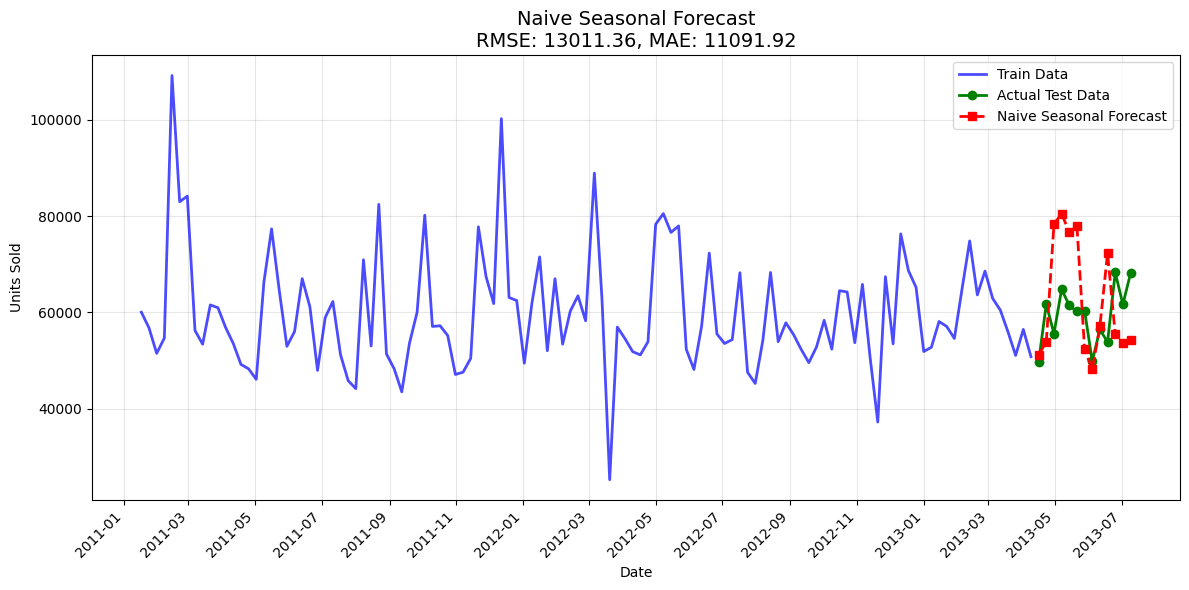

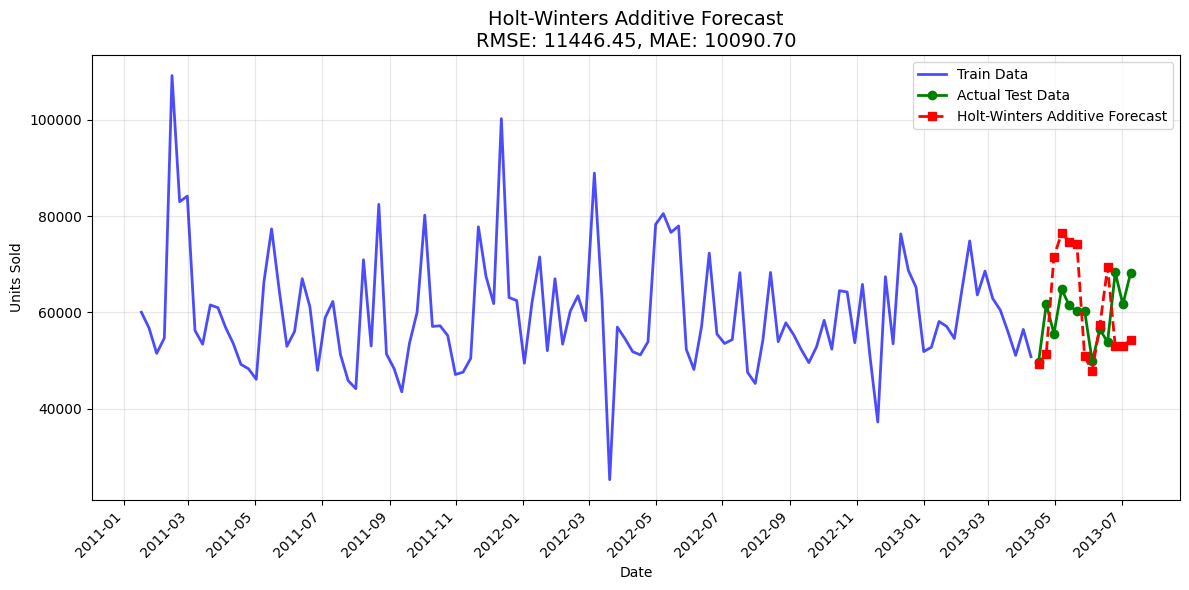

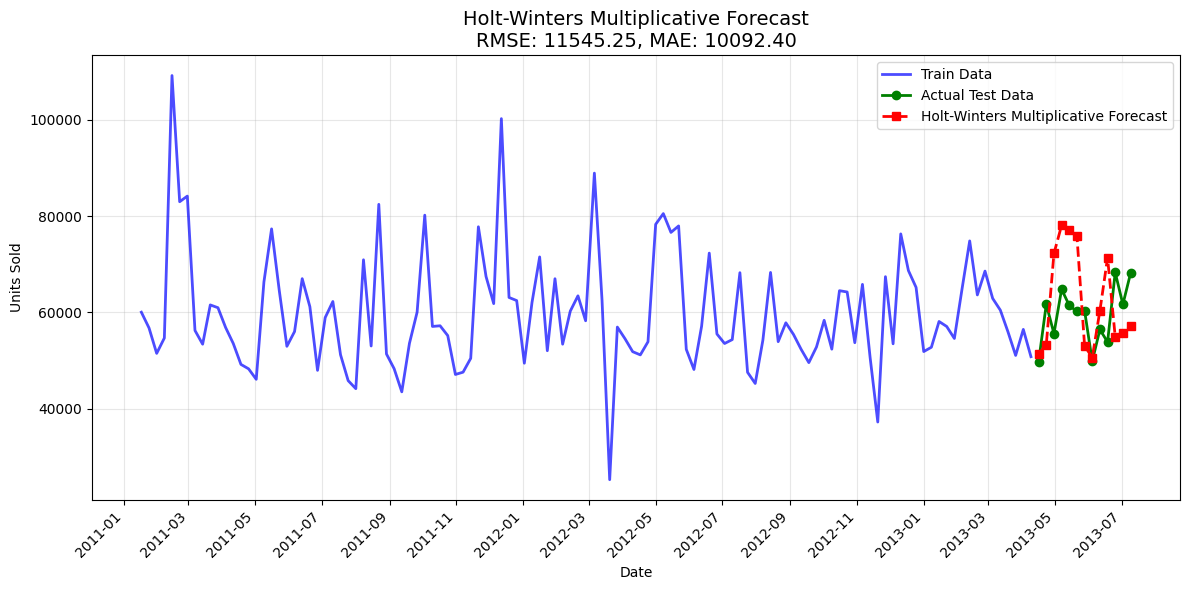

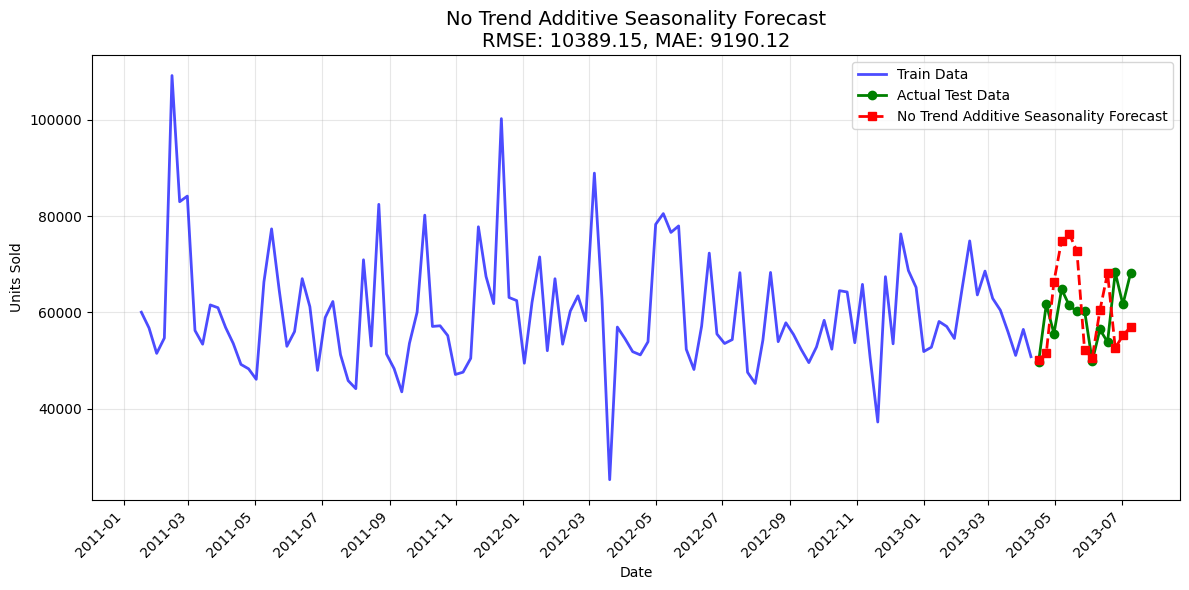

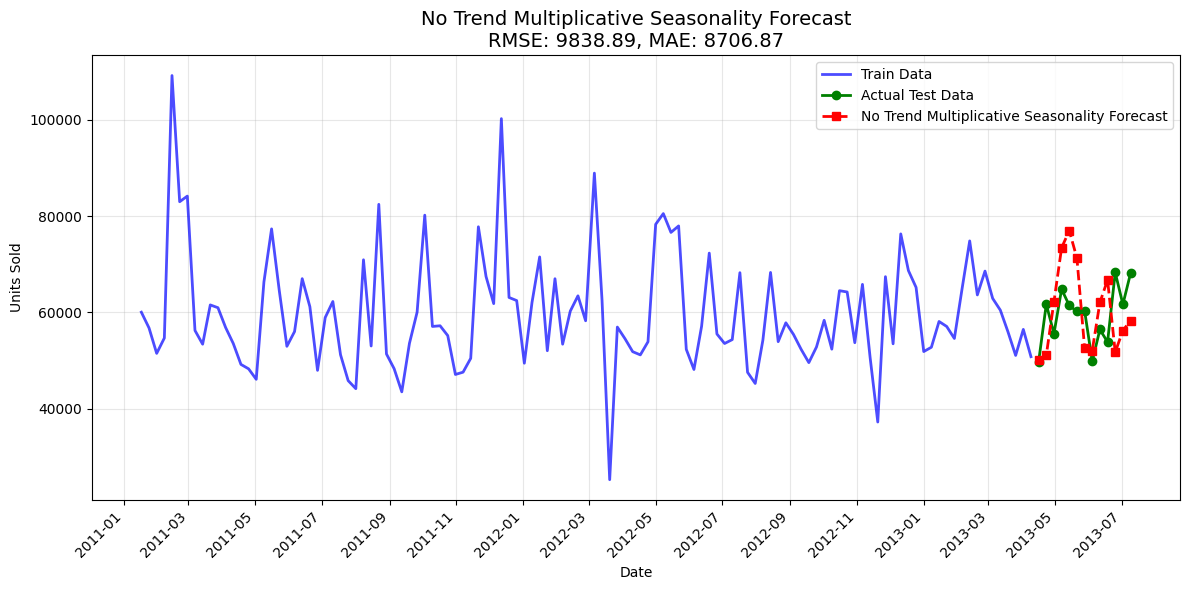

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

def load_train_data(train_path):
    train = pd.read_csv(train_path)
    train['week'] = pd.to_datetime(train['week'], format='%d/%m/%y')
    return train

def aggregate_by_week(train):
    train_agg = train.groupby('week').agg({'units_sold': 'sum'}).reset_index()
    train_agg = train_agg.sort_values('week').reset_index(drop=True)
    return train_agg

def split_train_test(data, test_size=0.1):
    split_idx = int(len(data) * (1 - test_size))
    train = data[:split_idx].reset_index(drop=True)
    test = data[split_idx:].reset_index(drop=True)
    return train, test

def evaluate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2}

def naive_seasonal_forecast(train_series, test_length, seasonal_period=52):
    forecast = []
    for i in range(test_length):
        idx = len(train_series) - seasonal_period + (i % seasonal_period)
        if idx >= 0 and idx < len(train_series):
            forecast.append(train_series.iloc[idx])
        else:
            forecast.append(train_series.mean())
    return np.array(forecast)

def exponential_smoothing(train_series, test_length, seasonal_period=52, trend='add', seasonal='add', smoothing_level=None, smoothing_slope=None, smoothing_seasonal=None, optimized=True):
    model = ExponentialSmoothing(train_series,
                                 seasonal_periods=seasonal_period,
                                 trend=trend,
                                 seasonal=seasonal,
                                 initialization_method='estimated')
    fitted_model = model.fit(smoothing_level=smoothing_level,
                             smoothing_slope=smoothing_slope,
                             smoothing_seasonal=smoothing_seasonal,
                             optimized=optimized)
    forecast = fitted_model.forecast(test_length)
    return forecast.values

def plot_forecast(train_data, test_data, y_train, y_test, forecast, model_name):
    train_dates = train_data['week'].values
    test_dates = test_data['week'].values

    plt.figure(figsize=(12,6))
    plt.plot(train_dates, y_train, 'b-', label='Train Data', linewidth=2, alpha=0.7)
    plt.plot(test_dates, y_test, 'g-', label='Actual Test Data', linewidth=2, marker='o', markersize=6)
    plt.plot(test_dates, forecast, 'r--', label=f'{model_name} Forecast', linewidth=2, marker='s', markersize=6)

    metrics = evaluate_metrics(y_test, forecast)
    plt.title(f'{model_name} Forecast\nRMSE: {metrics["rmse"]:.2f}, MAE: {metrics["mae"]:.2f}', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def main():
    train = load_train_data('train_0irEZ2H.csv')
    train_agg = aggregate_by_week(train)
    train_data, test_data = split_train_test(train_agg, test_size=0.1)
    y_train = train_data['units_sold']
    y_test = test_data['units_sold']

    test_length = len(y_test)

    naive_forecast = naive_seasonal_forecast(y_train, test_length)
    plot_forecast(train_data, test_data, y_train, y_test, naive_forecast, 'Naive Seasonal')

    # Run multiple parameter versions of Exponential Smoothing
    versions = [
        {'trend': 'add', 'seasonal': 'add', 'name': 'Holt-Winters Additive'},
        {'trend': 'mul', 'seasonal': 'mul', 'name': 'Holt-Winters Multiplicative'},
        {'trend': None, 'seasonal': 'add', 'name': 'No Trend Additive Seasonality'},
        {'trend': None, 'seasonal': 'mul', 'name': 'No Trend Multiplicative Seasonality'},
    ]

    for params in versions:
        try:
            forecast = exponential_smoothing(y_train, test_length,
                                             seasonal_period=52,
                                             trend=params['trend'],
                                             seasonal=params['seasonal'])
            plot_forecast(train_data, test_data, y_train, y_test, forecast, params['name'])
        except Exception as e:
            print(f"Exponential Smoothing {params['name']} failed with error: {e}")

if __name__ == "__main__":
    main()